## Building ChatBot with multiple tools using langgraph

In [2]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import  WikipediaAPIWrapper, ArxivAPIWrapper


In [6]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=5, doc_content_chars_max=5000)

arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=5000)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

print(arxiv.invoke("Attention is all you need?"))

Published: 2018-06-28
Title: Quit When You Can: Efficient Evaluation of Ensembles with Ordering Optimization
Authors: Serena Wang, Maya Gupta, Seungil You
Summary: Given a classifier ensemble and a set of examples to be classified, many examples may be confidently and accurately classified after only a subset of the base models in the ensemble are evaluated. This can reduce both mean latency and CPU while maintaining the high accuracy of the original ensemble. To achieve such gains, we propose jointly optimizing a fixed evaluation order of the base models and early-stopping thresholds. Our proposed objective is a combinatorial optimization problem, but we provide a greedy algorithm that achieves a 4-approximation of the optimal solution for certain cases. For those cases, this is also the best achievable polynomial time approximation bound unless $P = NP$. Experiments on benchmark and real-world problems show that the proposed Quit When You Can (QWYC) algorithm can speed-up average eva

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

tavily.invoke("What is best way to learn Gen AI?")

[{'title': 'How To Learn Generative AI From Scratch in 2026 - igmGuru',
  'url': 'https://www.igmguru.com/blog/how-to-learn-generative-ai',
  'content': "Q2. How to learn Generative AI for free?\n\nWant to build a career in Generative AI? This guide on 'how to learn Generative AI' will give you a deep understanding of Gen AI and help you become one. [...] Gen AI has become a huge field and at the pace at which it is expanding, its expansion is not going to stop anytime soon. This guide from experts paves a roadmap on how to learn generative AI from scratch. After all, a technology that is spreading like wildfire must bring in brilliant future opportunities too. Here is an introduction to generative AI.\n\n## What is Generative AI? [...] ### Step 1. Know the Basics of AI And ML\n\nThe first thing to do is to get to know the basics of gen AI. This includes understanding its models, tools, applications, and how it works. Having an in-depth understanding of these key factors will help you 

In [10]:
tools = [arxiv, wikipedia, tavily]

In [13]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [15]:
from langchain_core.messages import HumanMessage

llm_with_tools.invoke([HumanMessage(content="What is the capital of France?")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'France'},
  'id': 'qr5r0ssgy',
  'type': 'tool_call'}]

In [19]:
## entire chatbot with langgraph
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import  ToolNode, tools_condition


In [20]:
## State Schema

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

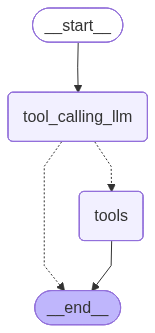

In [23]:
## node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages= graph.invoke({"messages":"India history"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

India history
================================== Ai Message ==================================
Tool Calls:
  wikipedia (mfg520evn)
 Call ID: mfg520evn
  Args:
    query: India history
================================= Tool Message =================================
Name: wikipedia

Page: History of India
Summary: Anatomically modern humans first arrived on the Indian subcontinent between 73,000 and 55,000 years ago. The earliest known human remains in South Asia date to 30,000 years ago. Sedentariness began in South Asia around 7000 BCE; by 4500 BCE, settled life had spread, and gradually evolved into the Indus Valley Civilisation, one of three early cradles of civilisation in the Old World, which flourished between 2500 BCE and 1900 BCE in present-day Pakistan and north-western India. Early in the second millennium BCE, persistent drought caused the population of the Indus Valley to scatter from large urb